So here I'm going to try not reusing all the posteriros for priors. I think it might be causing the issues.

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats
import threading
from multiprocessing.pool import ThreadPool
from astropy.table import Table
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 20

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise_Scalar(t, A, B, t0, trise, scalar):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))+scalar
def SuperNova_CurveFall_Scalar(t, A, B, t0, gamma, trise, tfall, scalar):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))+scalar

In [3]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))

In [4]:
def from_posteriors(param, samples):
    smins = []
    smaxs = []
    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))
    
    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x = np.linspace(smin, smax, 1000)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    return Interpolated(param, x, y)

In [5]:
def from_posterior(param, samples):
    smin, smax = np.min(samples[param]), np.max(samples[param])
    width = smax - smin
    x = np.linspace(smin, smax, 1000)
    y = stats.gaussian_kde(samples[param])(x)
    return Interpolated(param, x, y)

In [6]:
def make_curve(param, samples):
    smins = []
    smaxs = []

    for i in samples:
        smins.append(np.min(i[param]))
        smaxs.append(np.max(i[param]))

    

    smin = np.min(smins)
    smax = np.max(smaxs)
    width = smax - smin

    x, step = np.linspace(smin, smax, 1000, retstep = True)
    ys = []
    for i in samples:
        ys.append(stats.gaussian_kde(i[param])(x))
    y = np.prod(ys, axis = 0)
    y = y + np.exp(-100)
    y_norm = y / (np.sum(y)*step)
    return param, x, y_norm
def make_prior(posterior_param):
    return Interpolated(posterior_param[0],posterior_param[1],posterior_param[2])

In [7]:
def model_run(model,i,trace, iterations, core):
    with model:
        # 10000 posterior samples
        trace[i] = pm.sample(iterations, cores = core)

In [8]:
ztf_data = Table.read("flux_obs_19yvq.csv")

In [9]:
filter_types = np.unique(ztf_data["filt"])[3:6]
filter_number = np.size(filter_types)

In [10]:
end_A = np.max(ztf_data["t_restframe"])

In [11]:
#This is the test data we are going to use for a test
time_axis_filters = []
Y_observed_filter = []
Y_unc = []
scale = 1000000
ztf_data = ztf_data[3:-1]
for i in filter_types:
    print(i)
    time_axis_filters.append(np.asarray(ztf_data["t_restframe"][np.where(ztf_data["filt"] == i)]))
    light_data = np.asarray(ztf_data["flux_Jy"][np.where(ztf_data["filt"] == i)])
    Y_observed_filter.append(light_data * scale)
    light_data_unc = np.asarray(ztf_data["flux_unc_Jy"][np.where(ztf_data["filt"] == i)])
    Y_unc.append(light_data_unc * scale)

g
i
r


Text(0.5, 1.0, 'Observed Light Curve')

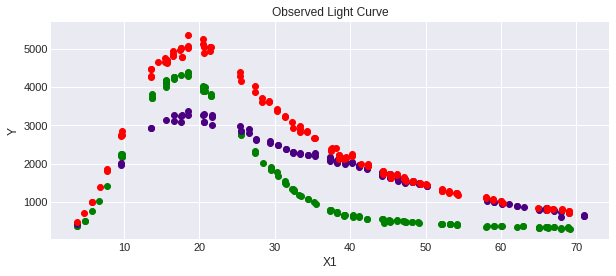

In [12]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
colours = ["green", "indigo", "red"]
for i in range(filter_number):
    #axes.scatter(time_axis_filters[i], Y_observed_filter[i], color = colours[i])
    axes.errorbar(time_axis_filters[i], Y_observed_filter[i], Y_unc[i], fmt = "o", color = colours[i])

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

In [16]:
model_filters = []
for i in range(filter_number):
    model_filters.append(pm.Model())

In [17]:
for i in range(filter_number):
    with model_filters[i]:

        # Priors for unknown model parameters

        trise = pm.Uniform('trise', lower = 0.01, upper = 50)
        tfall = pm.Uniform('tfall', lower = 1, upper = 300)
        
        Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
        Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
        
        Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i])/150, upper = 0)
        
        location_high = time_axis_filters[i][np.argmax(Y_observed_filter[i])]
        t0 = pm.Uniform('t0', lower = 0, upper = location_high)
        
        sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
        sigma = pm.HalfNormal('sigma', sigma=sigma_est)
        
        limits = np.absolute(np.max(Y_observed_filter[i]))
        scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

        #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
        no_p = pm.Normal.dist(mu = 5, sigma = 5)
        yes_p = pm.Normal.dist(mu = 60, sigma = 30)

        gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
        #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
        mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])
    
    

In [18]:
trace = []
for basic_model in model_filters:
    with basic_model:
        # 10000 posterior samples
        iterations = int(200000/core_count)
        tune_i = int(iterations/10)
        start = pm.find_MAP(model=basic_model)
        trace.append(pm.sample(iterations, tune = tune_i, cores = core_count, start = start))

logp = -824.4, ||grad|| = 0.090357: 100%|██████████| 164/164 [00:00<00:00, 1535.07it/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [gamma, scalar, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 0 divergences: 100%|██████████| 210000/210000 [01:47<00:00, 1950.48draws/s]
The acceptance probability does not match the target. It is 0.909948603392627, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915595687997737, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866924646860234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898803984974436, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probabil

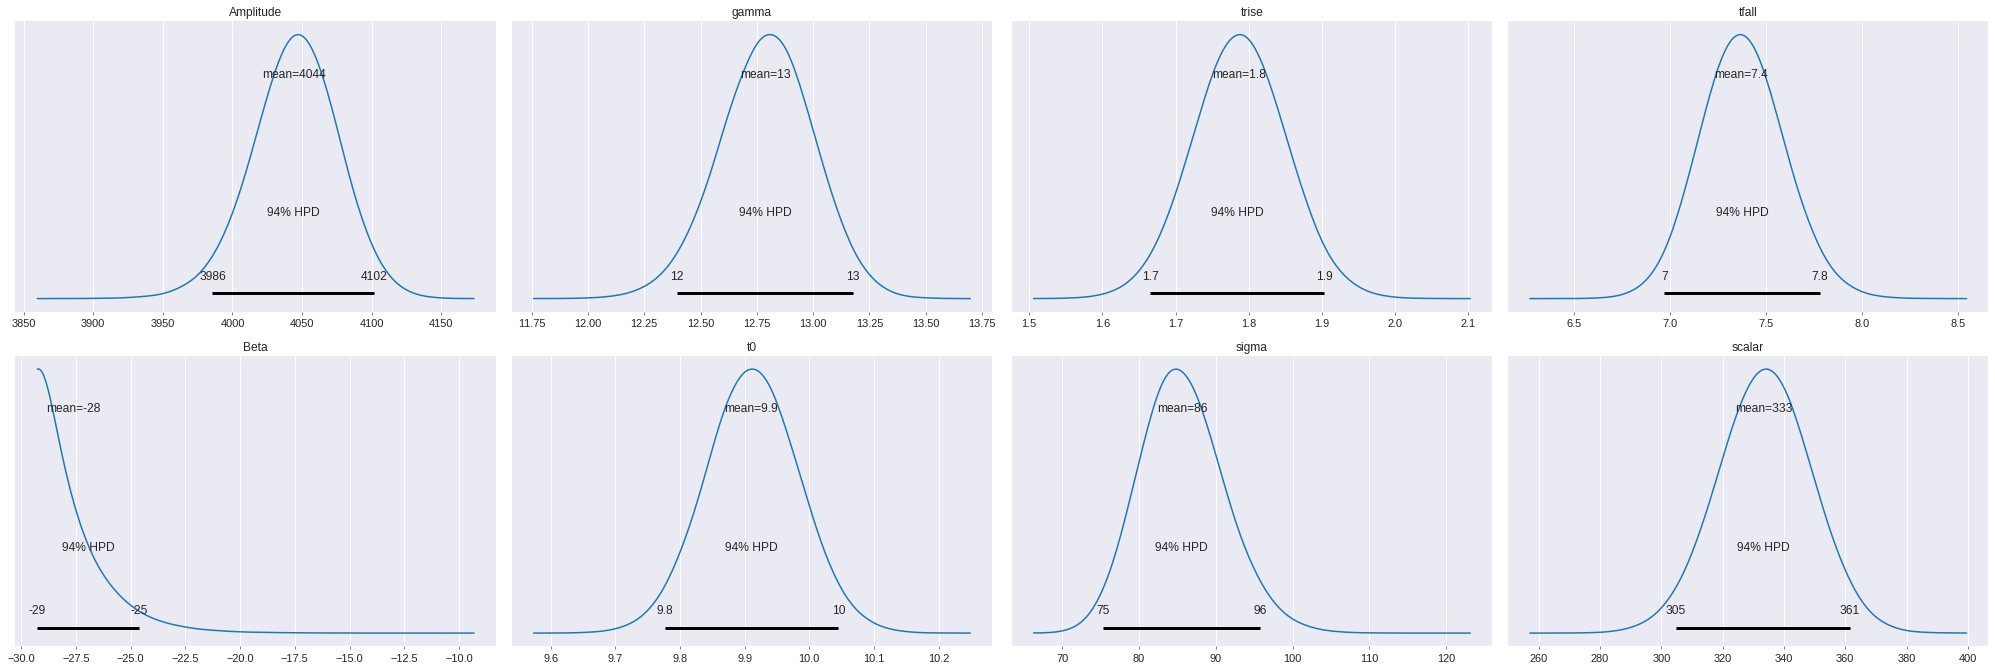

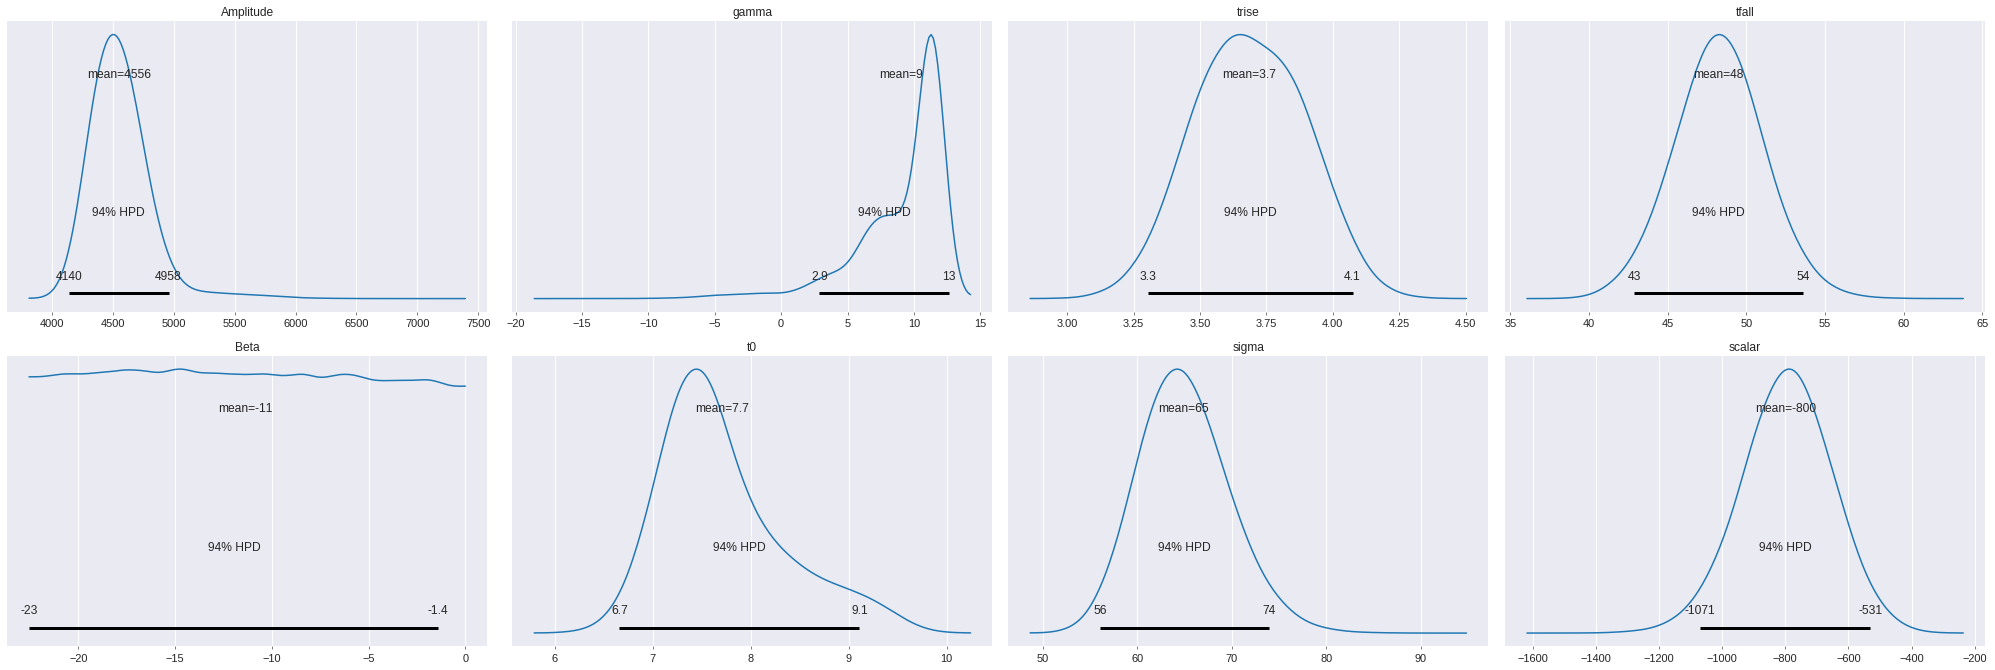

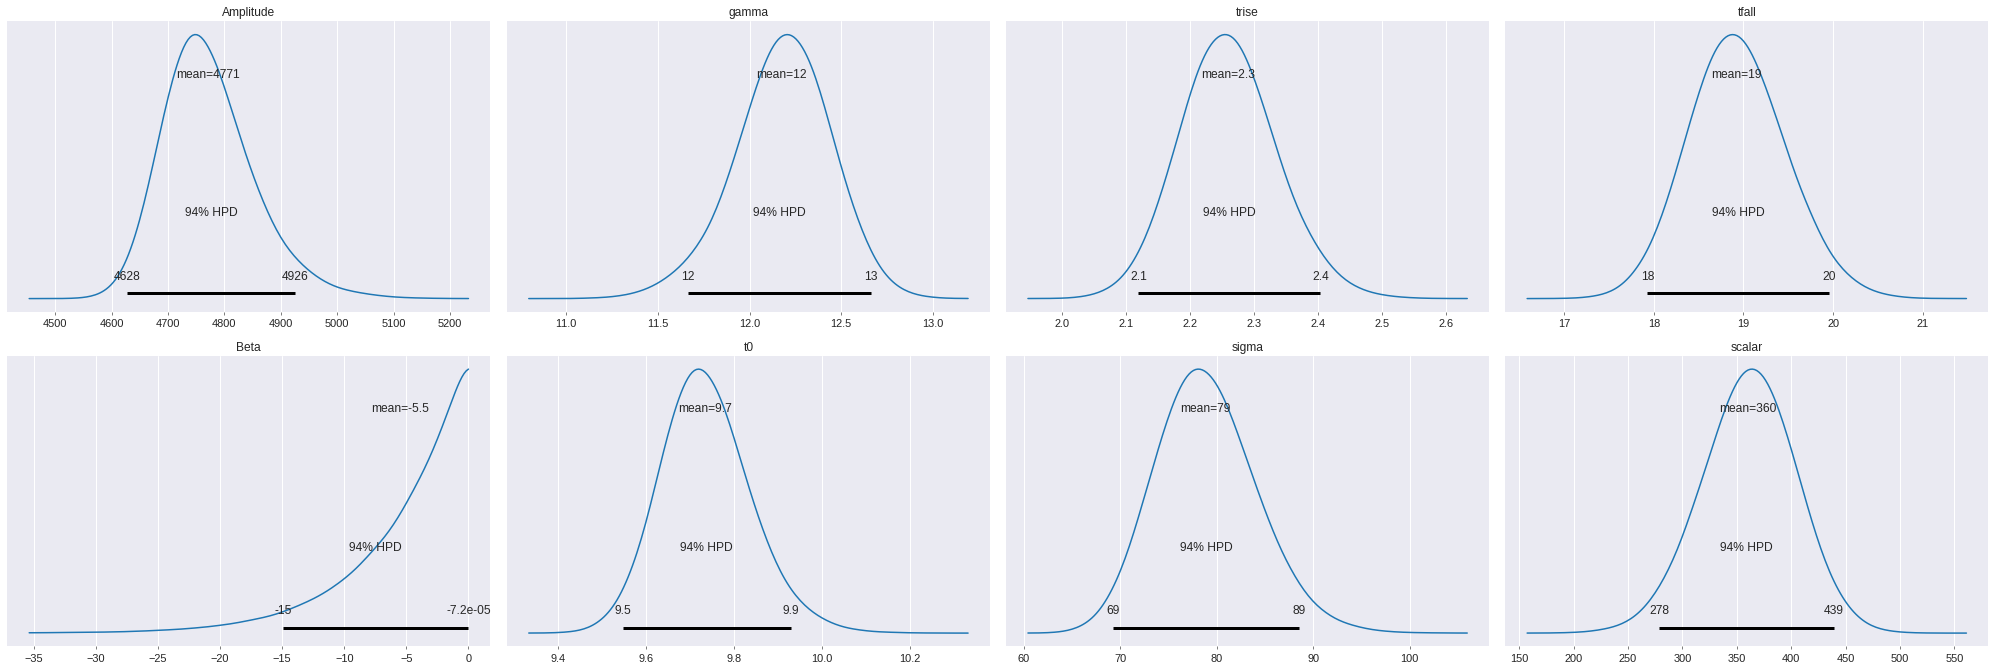

In [31]:
for posterior in trace:
    pm.plot_posterior(posterior)

In [ ]:
combined_model = []
for i in range(filter_number):
    combined_model.append(pm.Model())

In [ ]:
t0_posterior = make_curve("t0", trace)

gamma_posterior = make_curve("gamma", trace)

In [ ]:
for i in range(filter_number):
    with combined_model[i]:
        trise = pm.Uniform('trise', lower = 0.01, upper = 50)
        
        tfall = pm.Uniform('tfall', lower = 1, upper = 300)
        
        Amp_Guess = np.max(Y_observed_filter[i])-np.min(Y_observed_filter[i])
        Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)

        Beta = pm.Uniform('Beta', lower = -np.max(Y_observed_filter[i])/150, upper = 0)

        t0 = make_prior(t0_posterior)

        sigma_est = np.sqrt(np.sum(Y_unc[i]**2))
        sigma = pm.HalfNormal('sigma', sigma=sigma_est)

        gamma = make_prior(gamma_posterior)
        
        limits = np.absolute(np.max(Y_observed_filter[i]))
        scalar = pm.Uniform('scalar', lower = -limits, upper = limits)

        # Expected value of outcome
        mu_rise = SuperNova_CurveRise_Scalar(time_axis_filters[i], Amplitude, Beta, t0, trise, scalar)
        mu_fall = SuperNova_CurveFall_Scalar(time_axis_filters[i], Amplitude, Beta, t0, gamma, trise, tfall, scalar)

        mu_switch = pm.math.switch(gamma+t0 >= time_axis_filters[i], mu_rise, mu_fall)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed_filter[i])

In [24]:
trace_all = []
for basic_model in combined_model:
    with basic_model:
        # 10000 posterior samples
        iterations = int(200000/core_count)
        tune_i = int(iterations/10)
        start = pm.find_MAP(model=basic_model)
        trace_all.append(pm.sample(iterations, tune = tune_i, cores = core_count, start = start))

logp = -872.66, ||grad|| = 0.44587: 100%|██████████| 82/82 [00:00<00:00, 1086.48it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 0 divergences: 100%|██████████| 210000/210000 [01:35<00:00, 2191.22draws/s]
The acceptance probability does not match the target. It is 0.8811989121193609, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -654.95, ||grad|| = 1.1249: 100%|██████████| 160/160 [00:00<00:00, 1373.97it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (20 chains in 20 jobs)
NUTS: [scalar, gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 20 chains, 1 divergences: 100%|██████████| 210000/210000 [02:58<00:00, 1177.38draws/s]
The acceptance probability does not match the target. It is 0.9178729709104143, but should be close to 0.8.

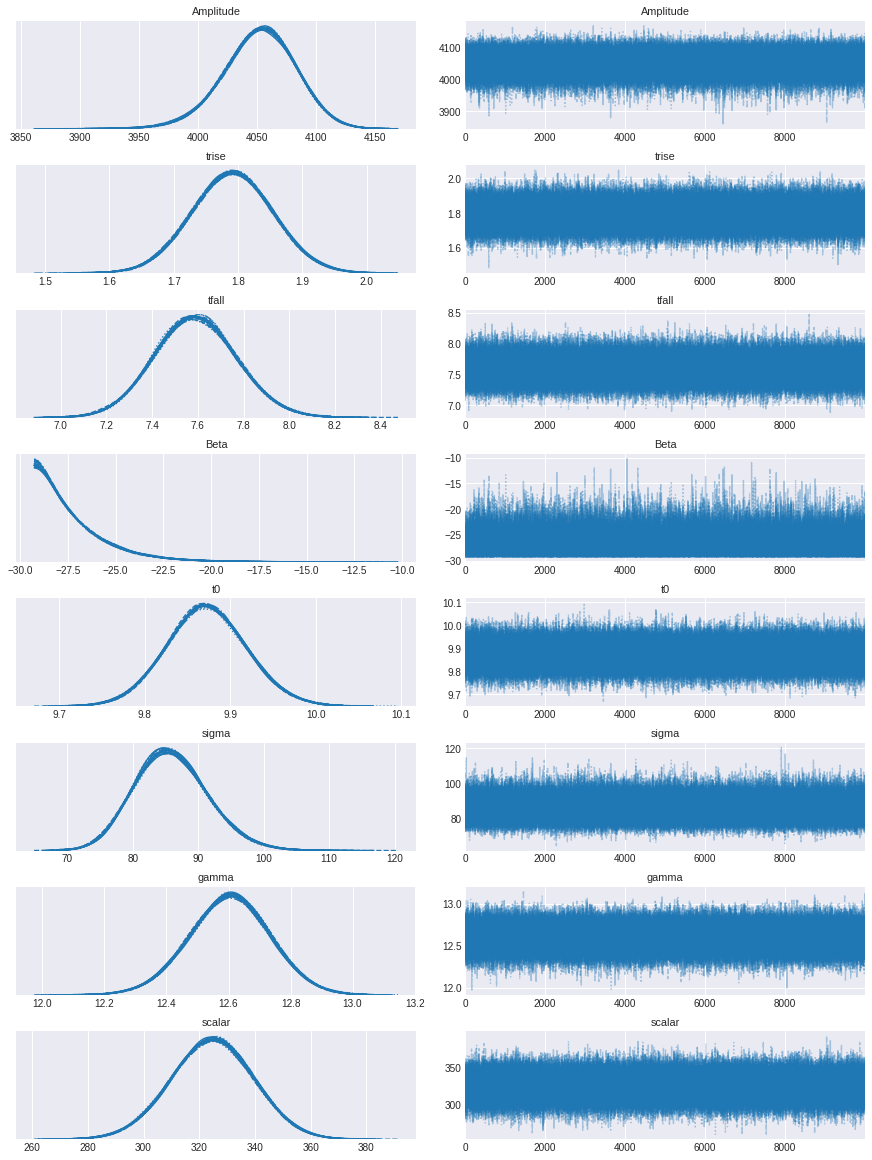

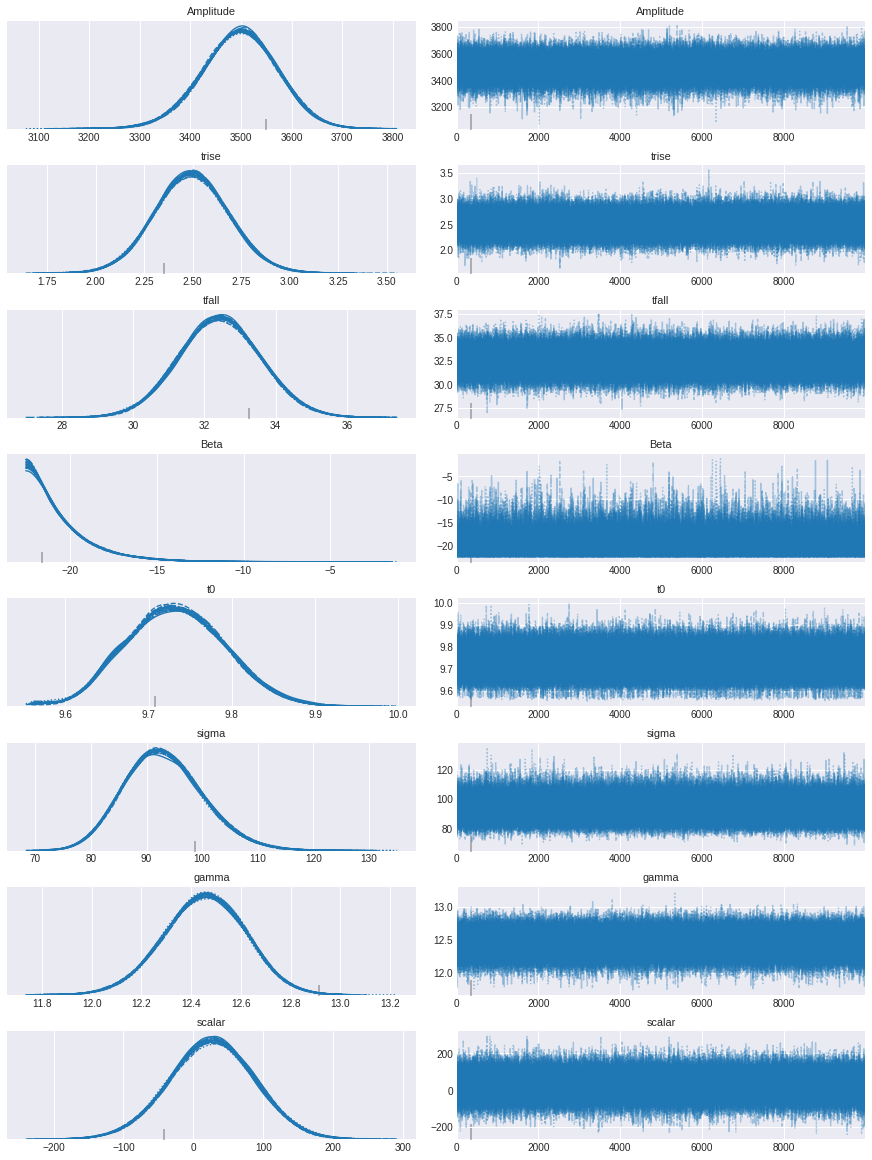

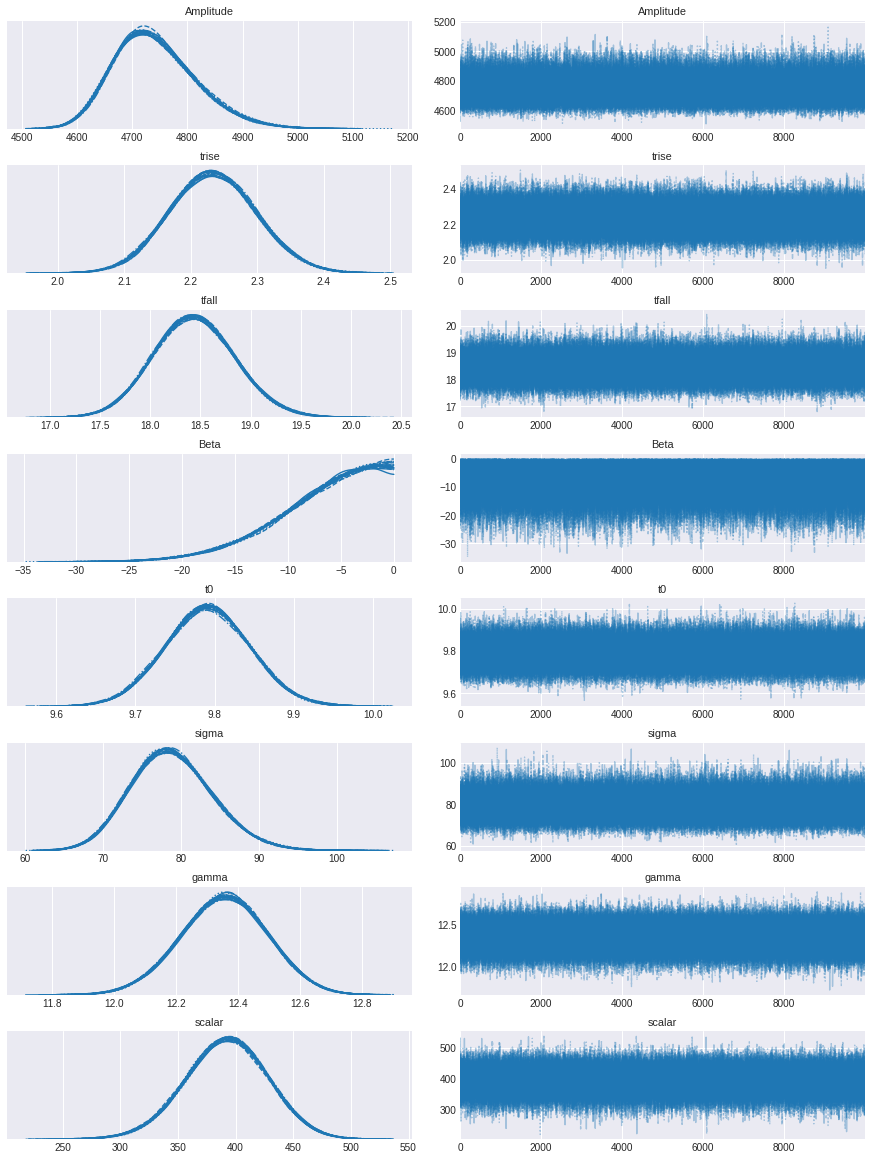

In [26]:
for i in trace_all:
    pm.traceplot(i)

In [27]:
summary_tables = []
for i in trace_all:
    summary_tables.append(pm.summary(i))

In [28]:
trise_R = []
tfall_R = []
Amplitude_R = []
Beta_R = []
t0_R = []
gamma_R = []
scalar_R = []
for i in summary_tables:
    trise_R.append(i["mean"]["trise"])
    tfall_R.append(i["mean"]["tfall"])
    Amplitude_R.append(i["mean"]["Amplitude"])
    Beta_R.append(i["mean"]["Beta"])
    t0_R.append(i["mean"]["t0"])
    gamma_R.append(i["mean"]["gamma"])
    scalar_R.append(i["mean"]["scalar"])

In [29]:
print(trise_R)
print(tfall_R)
print(Amplitude_R)
print(Beta_R)
print(t0_R)
print(gamma_R)
print(scalar_R)

[1.791, 2.496, 2.234]
[7.591, 32.442, 18.444]
[4051.964, 3497.389, 4742.238]
[-27.283, -20.607, -6.652]
[9.873, 9.733, 9.792]
[12.603, 12.454, 12.355]
[324.687, 26.931, 392.214]


Text(0, 0.5, 'y_observed')

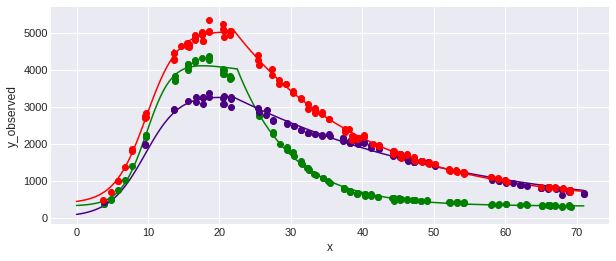

In [30]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))
colours = ["green", "indigo", "red"]

for i in range(filter_number):
    big_time_axis_rise = np.linspace(0,t0_R[i]+gamma_R[i],num = 100)
    ax.plot(big_time_axis_rise, SuperNova_CurveRise_Scalar(big_time_axis_rise, Amplitude_R[i], Beta_R[i], t0_R[i], trise_R[i], scalar_R[i]), color = colours[i])

for i in range(filter_number):
    big_time_axis_fall = np.linspace(t0_R[i]+gamma_R[i],end_A,num = 100)
    ax.plot(big_time_axis_fall, SuperNova_CurveFall_Scalar(big_time_axis_fall, Amplitude_R[i], Beta_R[i], t0_R[i], gamma_R[i], trise_R[i], tfall_R[i], scalar_R[i]), color = colours[i])

for i in range(filter_number):
    ax.errorbar(time_axis_filters[i], Y_observed_filter[i], Y_unc[i], fmt = "o", color = colours[i])
    
ax.set_xlabel('x')
ax.set_ylabel('y_observed')